<a href="https://colab.research.google.com/github/toraaglobal/deeplearning/blob/pytorch/Fixed_Feature_Extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning - Fixed Feature Extractor


## Creating and using a Fixed Feature Extractor


In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=True, download=True,transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Extracting /root/.pytorch/CIFAR10/cifar-10-python.tar.gz to /root/.pytorch/CIFAR10


In [5]:
model = models.vgg16(pretrained=True)
model 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [8]:
for param in model.parameters():
    param.require_grad = False

In [9]:
model.classifier[-1] = nn.Sequential(
    nn.Linear(in_features=4096, out_features=10),
    nn.LogSoftmax(dim=1)
)

In [10]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [11]:
criterion = nn.NLLLoss()

## Training the Fixed Feature Extractor

In [12]:
from torch.optim import Adam

model = model.to(device)
optimizer = Adam(model.parameters())

In [13]:
num_epochs = 1
batch_loss = 0
cum_epoch_loss = 0

for e in range(num_epochs):
  cum_epoch_loss = 0
  
  for batch, (images, labels) in enumerate(trainloader,1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})  Batch loss : {loss.item()}')
    
  print(f'Training loss : {batch_loss/len(trainloader)}')  
    

Epoch(0/1 : Batch number(1/782)  Batch loss : 2.3709750175476074
Epoch(0/1 : Batch number(2/782)  Batch loss : 4.291493892669678
Epoch(0/1 : Batch number(3/782)  Batch loss : 2.792738676071167
Epoch(0/1 : Batch number(4/782)  Batch loss : 2.3072171211242676
Epoch(0/1 : Batch number(5/782)  Batch loss : 2.6015641689300537
Epoch(0/1 : Batch number(6/782)  Batch loss : 2.4471254348754883
Epoch(0/1 : Batch number(7/782)  Batch loss : 2.33199405670166
Epoch(0/1 : Batch number(8/782)  Batch loss : 8.831136703491211
Epoch(0/1 : Batch number(9/782)  Batch loss : 2.316214084625244
Epoch(0/1 : Batch number(10/782)  Batch loss : 2.295485019683838
Epoch(0/1 : Batch number(11/782)  Batch loss : 2.3877921104431152
Epoch(0/1 : Batch number(12/782)  Batch loss : 2.3101022243499756
Epoch(0/1 : Batch number(13/782)  Batch loss : 2.3085148334503174
Epoch(0/1 : Batch number(14/782)  Batch loss : 2.294548988342285
Epoch(0/1 : Batch number(15/782)  Batch loss : 2.326667308807373
Epoch(0/1 : Batch number(16/

## Evaluating thet network and viewing images

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [15]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  print(output)


tensor([[8.9535e-03, 7.5406e-03, 5.6266e-02, 3.7977e-01, 4.3507e-02, 3.1659e-01,
         1.0192e-01, 4.9868e-02, 1.0199e-02, 2.5390e-02],
        [1.4623e-01, 7.1989e-01, 5.1238e-04, 1.3510e-04, 1.4238e-04, 5.9781e-05,
         4.5455e-05, 7.0501e-05, 1.1587e-01, 1.7052e-02],
        [7.6202e-02, 4.1724e-01, 1.2448e-02, 1.7354e-02, 3.4782e-03, 7.3347e-03,
         4.8429e-03, 5.1707e-03, 3.4122e-01, 1.1471e-01],
        [1.3886e-01, 6.0757e-02, 4.7615e-02, 2.6918e-02, 1.3427e-02, 9.1419e-03,
         1.1009e-02, 1.1353e-02, 6.5229e-01, 2.8634e-02],
        [1.4741e-03, 1.3981e-04, 2.3928e-01, 8.9422e-02, 4.2875e-01, 5.8464e-02,
         1.7348e-01, 7.9596e-03, 3.3572e-04, 6.9183e-04],
        [1.0207e-04, 3.0435e-05, 6.3103e-02, 2.0987e-01, 9.7681e-02, 1.0167e-01,
         5.2187e-01, 5.4416e-03, 4.4075e-05, 1.9090e-04],
        [1.3693e-02, 1.9323e-01, 2.1804e-02, 6.2643e-02, 8.6214e-03, 6.0262e-02,
         7.4197e-02, 1.2132e-02, 1.1946e-02, 5.4147e-01],
        [1.4617e-03, 1.0735

In [16]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  
  pred = torch.argmax(output,1)
    
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

car
deer
frog
cat


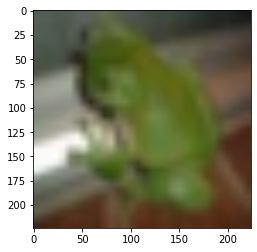

In [17]:
test_image_id=[2,4,5,7]

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id]

for i in test_image_id:
  show_img(images[i])
  print(get_CIFAR10_class(pred[i]))

ship


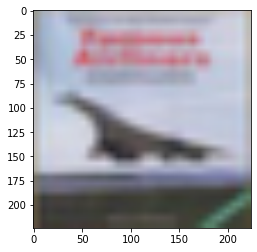

In [18]:
test_image_id= 3

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id]

show_img(images[test_image_id])
print(get_CIFAR10_class(pred[test_image_id]))

## Viewing images & normalization - Under the hood

In [19]:
pred

tensor([3, 1, 1, 8, 4, 6, 9, 3, 4, 1, 0, 9, 3, 6, 9, 2, 3, 3, 8, 6, 7, 0, 2, 9,
        4, 5, 6, 2, 9, 6, 6, 4, 2, 5, 9, 2, 4, 9, 9, 5, 4, 6, 7, 6, 8, 9, 5, 7,
        4, 2, 9, 2, 2, 6, 8, 2, 6, 3, 3, 3, 7, 3, 6, 3])

In [20]:
images.size()

torch.Size([64, 3, 224, 224])

In [21]:
images[0].size()

torch.Size([3, 224, 224])

In [ ]:
plt.imshow()

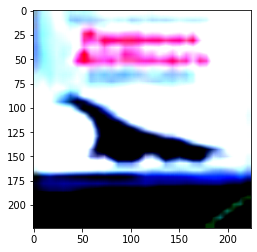

In [25]:
plt.imshow(np.clip(np.transpose(images[test_image_id],(1,2,0)),0,1))

In [ ]:
z = (x- mean)/ std

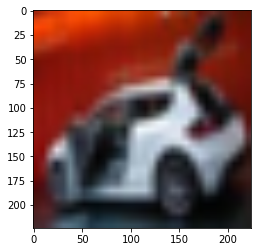

In [28]:
show_img(images[6])

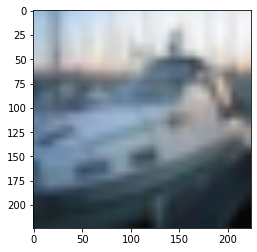

In [29]:
show_img(images[2])

## Accuracy of the model

In [30]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0

    cnt = 0
    #set_trace()
    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)
        print(output)
        cnt+=1
        
        if cnt > 0:
          break

tensor([[8.9535e-03, 7.5406e-03, 5.6266e-02, 3.7977e-01, 4.3507e-02, 3.1659e-01,
         1.0192e-01, 4.9868e-02, 1.0199e-02, 2.5390e-02],
        [1.4623e-01, 7.1989e-01, 5.1238e-04, 1.3510e-04, 1.4238e-04, 5.9781e-05,
         4.5455e-05, 7.0501e-05, 1.1587e-01, 1.7052e-02],
        [7.6202e-02, 4.1724e-01, 1.2448e-02, 1.7354e-02, 3.4782e-03, 7.3347e-03,
         4.8429e-03, 5.1707e-03, 3.4122e-01, 1.1471e-01],
        [1.3886e-01, 6.0757e-02, 4.7615e-02, 2.6918e-02, 1.3427e-02, 9.1419e-03,
         1.1009e-02, 1.1353e-02, 6.5229e-01, 2.8634e-02],
        [1.4741e-03, 1.3981e-04, 2.3928e-01, 8.9422e-02, 4.2875e-01, 5.8464e-02,
         1.7348e-01, 7.9596e-03, 3.3572e-04, 6.9183e-04],
        [1.0207e-04, 3.0435e-05, 6.3103e-02, 2.0987e-01, 9.7681e-02, 1.0167e-01,
         5.2187e-01, 5.4416e-03, 4.4075e-05, 1.9090e-04],
        [1.3693e-02, 1.9323e-01, 2.1804e-02, 6.2643e-02, 8.6214e-03, 6.0262e-02,
         7.4197e-02, 1.2132e-02, 1.1946e-02, 5.4147e-01],
        [1.4617e-03, 1.0735

In [31]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0

    cnt = 0

    for images, labels in testloader:
        
        logps = model(images)
        output = torch.exp(logps)

        pred = torch.argmax(output, 1)
        total += labels.size(0)        

        cnt+=1
        
        if cnt > 0:
          break

In [32]:
model.eval()
with torch.no_grad():
    num_correct = 0
    total = 0


    for batch, (images, labels) in enumerate(testloader,1):
        
        logps = model(images)
        output = torch.exp(logps)
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        print(f'Batch ({batch}/{len(testloader)})')
        
        if batch == 5:
          break

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/157)
Batch (2/157)
Batch (3/157)
Batch (4/157)
Batch (5/157)
Accuracy of the model on 320 test images: 50.625% 
